In [1]:
import sys 
sys.path.append("../")

In [2]:
from mps_utils import * 
from wave_circuit import * 
import matplotlib.pyplot as plt 
import pickle

In [3]:
f1 = lambda x :  np.exp(-(x/2-0.5)**2/0.01)
df1 = lambda x: ( -(x/2-0.5)/(0.01) ) * f1(x)

f2 = lambda x :  (x/2-0.5)/0.01 * f1(x)
df2 = lambda x: (x/2-0.5)/0.01 * df1(x) + 50 * f1(x)

f3 = lambda x: (1-(x/2-0.5)**2/0.01) * f1(x)
df3 = lambda x: -(x/2-0.5)/0.01 * f1(x) + (1-(x/2-0.5)**2/0.01)*df1(x)

m = 4
l = 2**m
x_coarse = np.linspace(0,1,l+1)

In [4]:
n = 10
N = 2**(n+1)
x = np.linspace(0, 1 - 1/N, N)

In [5]:
p1 = get_polys(x_coarse,f1,df1)
p2 = get_polys(x_coarse,f2,df2)
p3 = get_polys(x_coarse,f3,df3)

def apply(p,x):
    return np.dot(p,[x**i for i in range(len(p))])

In [ ]:
M_list1 = []
for i,p in enumerate(p1):
    reg = [i//2**_%2 for _ in range(m)[::-1]]
    M = MPS_poly(n,p,reg)
    M_list1.append(M)

M_full1 = (reduce(lambda a,b: MPS_sum(a,b),M_list1))

M_list2 = []
for i,p in enumerate(p2):
    reg = [i//2**_%2 for _ in range(m)[::-1]]
    M = MPS_poly(n,p,reg)
    M_list2.append(M)

M_full2 = (reduce(lambda a,b: MPS_sum(a,b),M_list2))

M_list3 = []
for i,p in enumerate(p3):
    reg = [i//2**_%2 for _ in range(m)[::-1]]
    M = MPS_poly(n,p,reg)
    M_list3.append(M)

M_full3 = (reduce(lambda a,b: MPS_sum(a,b),M_list3))

M_final1 = trunc_mps(M_full1,2)
M_final2 = trunc_mps(M_full2,2)
M_final3 = trunc_mps(M_full3,2)

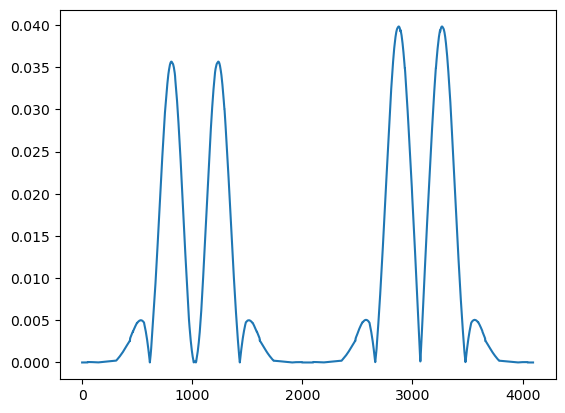

In [28]:
circ1 = QuantumCircuit(n+1)
circ1.append(circ_from_layers(get_layers(M_final1,1)), range(1,n+1))
circ1.h(0)
for i in range(1,n+1):
    circ1.cx(0,i)
    
circ2 = QuantumCircuit(n+1)
circ2.append(circ_from_layers(get_layers(M_final2,1)), range(1,n+1))
circ2.h(0)
circ2.z(0)
for i in range(1,n+1):
    circ2.cx(0,i)
    
circ3 = QuantumCircuit(n+1)
circ3.append(circ_from_layers(get_layers(M_final3,1)), range(1,n+1))
circ3.h(0)
for i in range(1,n+1):
    circ3.cx(0,i)
from qiskit.circuit import Parameter, QuantumCircuit 
t  = Parameter('t')

M3_evo_circ = QuantumCircuit(n+2)
M3_evo_circ = M3_evo_circ.compose(circ3, range(1,n+2))
M3_evo_circ = M3_evo_circ.compose(evolve_circ_P(n+1,t), range(0,n+2))

from qiskit.quantum_info import Statevector
plt.plot(abs(Statevector(M3_evo_circ.assign_parameters([0.1]).reverse_bits()).data))


In [ ]:
from qiskit.circuit import Parameter, QuantumCircuit 

t  = Parameter('t')

M1_evo_circ = QuantumCircuit(n+2)
M1_evo_circ = M1_evo_circ.compose(circ1, range(1,n+2))
M1_evo_circ = M1_evo_circ.compose(evolve_circ_P(n+1,t), range(0,n+2))

M2_evo_circ = QuantumCircuit(n+2)
M2_evo_circ = M2_evo_circ.compose(circ2, range(1,n+2))
M2_evo_circ = M2_evo_circ.compose(evolve_circ_P(n+1,t), range(0,n+2))

M3_evo_circ = QuantumCircuit(n+2)
M3_evo_circ = M3_evo_circ.compose(circ3, range(1,n+2))
M3_evo_circ = M3_evo_circ.compose(evolve_circ_P(n+1,t), range(0,n+2))

circs = [M1_evo_circ,M2_evo_circ,M3_evo_circ]

In [ ]:
from qiskit.quantum_info import Statevector
plt.plot((Statevector(M3_evo_circ.assign_parameters([0.1]).reverse_bits()).data).real)
# exact_Hamiltonian = Ham_P(N)
# initial_state = np.concatenate([f3(2*x)/np.linalg.norm(f3(2*x)), np.zeros(x.shape)])
# plt.plot(abs(expm(-1j * exact_Hamiltonian * 0.001) @ initial_state))

In [ ]:
from scipy.linalg import expm 
from matplotlib import cm
from qiskit.quantum_info import Statevector


exact_Hamiltonian = Ham_P(N)
time_steps = 11
dt = 0.05


exact_data = np.zeros((time_steps,3,2*len(x)),dtype=complex)
circuit_data = np.zeros((time_steps,3,2*len(x)),dtype=complex)
# Reduce figure size for a more compact layout
fig, ax = plt.subplots(time_steps, 3, figsize=(5, 15), sharex=True, sharey=True)
fig.suptitle("Time Evolution of Wavefunctions", fontsize=12,y=0.95)

functions = [f1, f2, f3]
titles = ['Initial Function f1(x)', 'Initial Function f2(x)', 'Initial Function f3(x)']

# Use a colormap to emphasize time evolution
cmap = cm.get_cmap("viridis", time_steps)
colors = [cmap(i) for i in range(time_steps)]

cmap1 = cm.get_cmap("cool", time_steps)
colors1 = [cmap1(i) for i in range(time_steps)]


for col in range(3):
    func = functions[col]
    initial_state = np.concatenate([func(2*x)/np.linalg.norm(func(2*x)), np.zeros(x.shape)])
    
    for row in range(time_steps):
        t = row * dt
        evolved_state = expm(-1j * exact_Hamiltonian * t) @ initial_state
        ax[row][col].plot(x, abs(evolved_state[:len(x)]),color='k',linewidth=0.5,label='Exact')
        ax[row][col].plot(x, abs(Statevector(circs[col].assign_parameters([t]).reverse_bits()).data)[:len(x)],linestyle='--',color=colors[row],linewidth=0.5,label='Trunc MPS')
        ax[row][col].legend(fontsize=4)
        
        exact_data[row,col,:] = evolved_state
        circuit_data[row,col,:] = Statevector(circs[col].assign_parameters([t]).reverse_bits()).data[:2*len(x)]
        
        # Label time on left-most column
        if col == 0:
            ax[row][col].set_ylabel(f"t = {t:.2f}", fontsize=7)
        
        # Set titles on top row
        if row == 0:
            ax[row][col].set_title(titles[col], fontsize=9)

        ax[row][col].tick_params(labelsize=5)  # Smaller tick labels
        ax[row][col].grid(True, linestyle=':', linewidth=0.5, alpha=0.6)

# Hide x-axis labels on all but last row
for row in range(time_steps - 1):
    for col in range(3):
        ax[row][col].set_xticklabels([])

# Set a common x-axis label
for col in range(3):
    ax[-1][col].set_xlabel("x", fontsize=8)

# Adjust layout to reduce space
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, top=0.9)  # Reduced hspace for a more compact layout
plt.savefig("../Figures/MPSFullEvolutionPer.pdf",dpi=300)
plt.show()

In [ ]:
p = 0.25

R_ops = C_ops = [np.sqrt(p) * np.eye(2), np.sqrt((1-p)/3) * np.array([[0,1],[1,0]]), np.sqrt((1-p)/3) * np.array([[0, -1j],[1j,0]]), np.sqrt((1-p)/3) * np.array([[1,0],[0,-1]])]


C_ops = [np.sqrt(1-p) * np.eye(2), np.sqrt(p/3) * np.array([[0,1],[1,0]]), np.sqrt(p/3) * np.array([[0, -1j],[1j,0]]), np.sqrt(p/3) * np.array([[1,0],[0,-1]])]


E_ops = [A,B,C]

In [ ]:
A = np.linalg.cholesky(
    np.array([[0.3,-.1j],[.1j, 0.3]])
).conjugate().T

B = np.linalg.cholesky(
    np.array([[0.3,.1j],[-.1j, 0.3]])
).conjugate().T

C = np.sqrt(0.4) * np.linalg.qr(np.random.random((2,2)) + np.random.random((2,2)) * 1j)[0]

A.conjugate().T @ A + B.conjugate().T @ B + C.conjugate().T @ C

In [ ]:
Phi = 1/np.sqrt(2) * np.array([1,0,0,1])

In [ ]:
new_phi = np.outer(Phi,Phi)
new_phi = sum([np.kron(np.eye(2), E) @ new_phi @ np.kron(np.eye(2), E.conjugate().T) for E in E_ops])
new_phi = sum([np.kron(np.eye(2), C) @ new_phi @ np.kron(np.eye(2), C.conjugate().T) for C in C_ops])
new_phi = sum([np.kron(np.eye(2), R) @ new_phi @ np.kron(np.eye(2), R.conjugate().T) for R in R_ops])


In [ ]:
np.trace(new_phi @ np.outer(Phi,Phi))

In [ ]:
XE = sum([np.kron(np.eye(2), E) @ np.outer(Phi,Phi) @ np.kron(np.eye(2), E.conjugate().T) for E in E_ops])
XR = sum([np.kron(np.eye(2), E) @ np.outer(Phi,Phi) @ np.kron(np.eye(2), E.conjugate().T) for E in R_ops])
XC = sum([np.kron(np.eye(2), E) @ np.outer(Phi,Phi) @ np.kron(np.eye(2), E.conjugate().T) for E in C_ops])

In [ ]:
ME = sum([np.kron(np.eye(2), E.T) @ XE.conjugate() @ np.kron(np.eye(2), E.conjugate()) for E in C_ops])

In [ ]:
np.trace(XR @ ME)

In [ ]:
XE

In [ ]:
ME

In [ ]:
E_ops[0].conjugate().T @ E_ops[0]

In [ ]:
E_ops[0].conjugate().T @ E_ops[0]+E_ops[1].conjugate().T @ E_ops[1]

In [ ]:
np.linalg.cholesky(np.eye(2)-E_ops[0].conjugate().T @ E_ops[0])